In [1]:
import glob
import os
import pickle
import time
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from scripts.gifMaker import make_gif_from_array
from src.common import as_intrinsics_matrix
from torch.utils.data import Dataset
import threading
from tqdm import tqdm
from src.utils.datasets import get_dataset
import time

import torch.multiprocessing as mp
from src.utils import backproject, create_instance_seg, id_generation, vis
import argparse
from src.NICE_SLAM import NICE_SLAM
from src import config
import seaborn as sns
from src.Segmenter import Segmenter

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
parser = argparse.ArgumentParser(
description="Arguments for running the NICE-SLAM/iMAP*."
)
parser.add_argument("config", type=str, help="Path to config file.")
parser.add_argument(
    "--input_folder",
    type=str,
    help="input folder, this have higher priority, can overwrite the one in config file",
)
parser.add_argument(
    "--output",
    type=str,
    help="output folder, this have higher priority, can overwrite the one in config file",
)
nice_parser = parser.add_mutually_exclusive_group(required=False)
nice_parser.add_argument("--nice", dest="nice", action="store_true")
nice_parser.add_argument("--imap", dest="nice", action="store_false")
parser.set_defaults(nice=True)
args = parser.parse_args(args=['configs/Own/room0.yaml'])
#args = parser.parse_args(args=['/home/rozenberszki/project/wsnsl/configs/Own/room0.yaml'])
cfg = config.load_config(  # J:changed it to use our config file including semantics
        args.config, "configs/nice_slam_sem.yaml" if args.nice else "configs/imap.yaml"
    )
cfg['tracking']['gt_camera'] = True
cfg['Segmenter']['full_slam'] = False
slam = NICE_SLAM(cfg, args)
frame_reader = get_dataset(cfg, args, cfg["scale"], slam = slam)
frame_reader.__post_init__(slam)
zero_pos = frame_reader.poses[0]
zero_pos

INFO: The output folder is output/Own/room0
INFO: The GT, generated and residual depth/color images can be found under output/Own/room0/mapping_vis/
INFO: The mesh can be found under output/Own/room0/mesh/
INFO: The checkpoint can be found under output/Own/room0/ckpt/


tensor([[-3.2057e-01, -4.4806e-01,  8.3455e-01,  3.4530e+00],
        [ 9.4722e-01, -1.5164e-01,  2.8244e-01,  4.5461e-01],
        [ 1.0790e-16,  8.8105e-01,  4.7302e-01,  5.9363e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]])

In [3]:
import os
import shutil

folder_path = '/home/rozenberszki/D_Project/wsnsl/Dataset/fe1733741f/test'


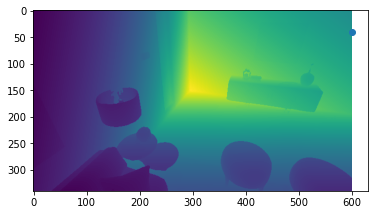

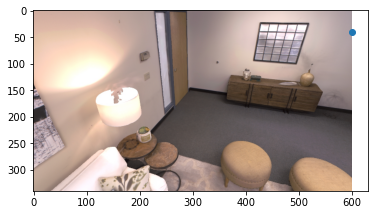

In [4]:
plt.imshow(frame_reader.get_colorAndDepth(0)[1].cpu())
plt.scatter(600,40)
plt.show()
plt.imshow(frame_reader.get_colorAndDepth(0)[0].cpu())
plt.scatter(600,40)

In [5]:
segmenter = Segmenter(slam, cfg, args, zero_pos, 'test')

In [6]:
segmenter.estimate_c2w_list = torch.from_numpy(np.concatenate([p[None] for p in segmenter.frame_reader.poses], axis=0))

In [7]:
import os
import shutil

folder_path = '/home/rozenberszki/project/wsnsl/test'

# Check if the folder exists
if os.path.exists(folder_path):
    # Delete the folder and its contents
    shutil.rmtree(folder_path)

# Create the folder
os.makedirs(folder_path)


In [9]:
segmenter.runAuto()

min are first:  600


Segmenting frames:   3%|▎         | 5/199 [00:06<04:12,  1.30s/it]

(22172, 3)


No handles with labels found to put in legend.


stored pointcloud


Segmenting frames:   4%|▎         | 7/199 [05:39<2:35:22, 48.55s/it] 


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [ ]:
import numpy as np
import open3d as o3d
points = np.random.rand(10,3)

In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(points)
pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))

# Step 2: Compute a mesh using the Ball Pivoting algorithm
# You may need to adjust the radii parameter based on the scale of your point cloud
radii = [0.005, 0.01, 0.02, 0.04]
mesh = o3d.geometry.TriangleMesh.create_from_point_cloud_ball_pivoting(
       pcd, o3d.utility.DoubleVector(radii))

# Step 3: Simplify the mesh (optional, if you need to reduce the complexity)
mesh_simplified = mesh.simplify_quadric_decimation(target_number_of_triangles=1000)
o3d.io.write_triangle_mesh("test_mesh.obj", mesh_simplified)

In [ ]:
frame_reader.n_img//50

In [ ]:
import seaborn as sns
for idx in range(0, frame_reader.n_img, 50):
    _,_, depth,_,_ = frame_reader[idx]
    sns.heatmap(depth.cpu().numpy() == 0)
    plt.show()
    plt.clf()


In [ ]:
color, depth= frame_reader.get_colorAndDepth(1000)
#_,depth = frame_reader.get_colorAndDepth(80)
color = color.cpu().numpy()
depth = depth.cpu().numpy()
depth = depth / np.max(depth)
depth = np.stack([depth, depth, depth], axis=-1)
fig, ax = plt.subplots(3, 1, figsize=(40, 13))
ax[0].imshow(depth)
#plt.show()
ax[1].imshow(color)
#plt.show()
ax[2].imshow(color*depth*5)